In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Module, Parameter
from torch.distributions.normal import Normal as NormalTorch
import torch.optim as optim
import math

In [66]:
class Distribution(Module):
    
    def __init__(self):
        super(Distribution, self).__init__()
        
    def log_prob(self, x):
        raise NotImplementedError("Log Prob Not Allowed")
        
    def sample(self):
        raise NotImplementedError("Sampling Not Allowed")
        

In [107]:
class Normal(Distribution):
    
    def __init__(self, means=None, stds=None, dims=1):
        super(Normal, self).__init__()
        if means is None:
            self.mu = Parameter(torch.Tensor(dims).uniform_(-1, 1))
        else:
            self.mu = means
        if stds is None:
            self.std = Parameter(torch.Tensor(dims).uniform_(0, 1))
        else:
            self.std = stds
        
    def log_prob(self, x):
        prob = torch.exp(-((x-self.mu)**2) / (2*(self.std**2)))
        prob = (1.0 / torch.sqrt(2 * math.pi * (self.std**2))) * prob
        return torch.log(prob+1e-10)
    
    def _sample(self):
        return self.mu + self.std * torch.randn(self.std.size())
    
    def sample(self, n=1):
        return torch.stack([self._sample() for _ in range(n)])

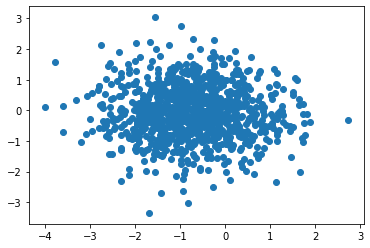

In [110]:
n = Normal(dims=2)
# plt.hist([n.sample().item() for _ in range(10000)], bins=100)
values = np.array([n.sample().detach().numpy()[0] for _ in range(1000)])
# plt.plot(n.sample()
plt.scatter(values[:, 0], values[:, 1])
plt.show()

In [111]:
def ForwardKL(samples, distribution):
    return -distribution.log_prob(samples).sum()

In [114]:
model = Normal(dims=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [115]:
samples = NormalTorch(torch.tensor([-3.0, 7.0]), torch.tensor([1.2, 3.54])).sample((1000,))
# samples = torch.normal(mean=torch.zeros(1000, 9).fill_(-2.5), 
#                        std=torch.ones(1000, 9).fill_(6.0))
samples

tensor([[-2.2456, 10.1697],
        [-3.6807,  8.9420],
        [-2.3216,  3.3399],
        ...,
        [-2.2066,  9.2644],
        [-1.7051,  0.5045],
        [-3.7253, 12.5195]])

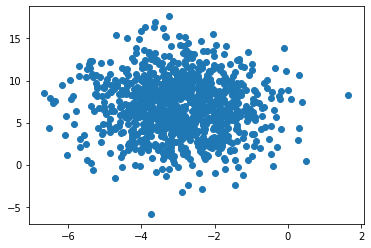

In [116]:
# model.log_prob(samples)
values = samples.numpy()
plt.scatter(values[:, 0], values[:, 1])
plt.show()

In [117]:
for i in range(3000):
    optimizer.zero_grad()

    loss = ForwardKL(samples, model)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

Epoch 0 Loss: 44412.949
Epoch 100 Loss: 14422.415
Epoch 200 Loss: 8109.435
Epoch 300 Loss: 6449.941
Epoch 400 Loss: 5683.000
Epoch 500 Loss: 5240.609
Epoch 600 Loss: 4956.557
Epoch 700 Loss: 4763.133
Epoch 800 Loss: 4626.985
Epoch 900 Loss: 4529.438
Epoch 1000 Loss: 4458.920
Epoch 1100 Loss: 4407.706
Epoch 1200 Loss: 4370.407
Epoch 1300 Loss: 4343.188
Epoch 1400 Loss: 4323.297
Epoch 1500 Loss: 4308.755
Epoch 1600 Loss: 4298.143
Epoch 1700 Loss: 4290.442
Epoch 1800 Loss: 4284.917
Epoch 1900 Loss: 4281.015
Epoch 2000 Loss: 4278.315
Epoch 2100 Loss: 4276.491
Epoch 2200 Loss: 4275.289
Epoch 2300 Loss: 4274.519
Epoch 2400 Loss: 4274.041
Epoch 2500 Loss: 4273.750
Epoch 2600 Loss: 4273.582
Epoch 2700 Loss: 4273.483
Epoch 2800 Loss: 4273.429
Epoch 2900 Loss: 4273.401


In [118]:
print(model.mu, model.std)

Parameter containing:
tensor([-2.9842,  6.9295], requires_grad=True) Parameter containing:
tensor([1.2218, 3.4496], requires_grad=True)


In [119]:
class Normal_No_Sample(Distribution):
    
    def __init__(self, means=None, stds=None, dims=1):
        super(Normal_No_Sample, self).__init__()
        if means is None:
            self.mu = torch.Tensor(dims).uniform_(-1, 1)
        else:
            self.mu = means
        if stds is None:
            self.std = torch.Tensor(dims).uniform_(0, 1)
        else:
            self.std = stds
        
    def log_prob(self, x):
        prob = torch.exp(-((x-self.mu)**2) / (2*(self.std**2)))
        prob = (1.0 / torch.sqrt(2 * math.pi * (self.std**2))) * prob
        return torch.log(prob+1e-10)

In [120]:
truth = Normal_No_Sample(torch.tensor([-3.0, 7.0]), torch.tensor([1.2, 3.54]))
model = Normal(dims=2)

print(truth.mu, truth.std)
print(model.mu, model.std)

tensor([-3.,  7.]) tensor([1.2000, 3.5400])
Parameter containing:
tensor([0.4145, 0.9870], requires_grad=True) Parameter containing:
tensor([0.3185, 0.7240], requires_grad=True)


In [121]:
def ReverseKL(q, p, batch_size=64):
    samples = q.sample(batch_size)
    return -(p.log_prob(samples) - q.log_prob(samples)).sum()
    

In [122]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [123]:
for i in range(1500):
    optimizer.zero_grad()

    loss = ReverseKL(model, truth)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.3f}")

Epoch 0 Loss: 455.035
Epoch 100 Loss: 227.143
Epoch 200 Loss: 79.470
Epoch 300 Loss: 52.769
Epoch 400 Loss: 31.116
Epoch 500 Loss: 15.348
Epoch 600 Loss: 7.319
Epoch 700 Loss: 2.776
Epoch 800 Loss: 3.751
Epoch 900 Loss: 2.023
Epoch 1000 Loss: -0.316
Epoch 1100 Loss: 0.332
Epoch 1200 Loss: -0.421
Epoch 1300 Loss: 0.065
Epoch 1400 Loss: -0.057


In [124]:
print(truth.mu, truth.std)
print(model.mu, model.std)

tensor([-3.,  7.]) tensor([1.2000, 3.5400])
Parameter containing:
tensor([-2.9812,  6.9653], requires_grad=True) Parameter containing:
tensor([1.2046, 3.5419], requires_grad=True)
